In [ ]:

## ->>>>>>>>>>>>> exemplo final 

→ 39 registros, 16 classes: ['+', '/', 'A', 'F', 'J', 'L', 'N', 'Q', 'R', 'V', 'X', 'a', 'b', 'f', 'j', '~']
→ Extraídos 118193 batimentos x 293 amostras
Epoch 1/50 — loss=0.4211 — acc=0.9015 — lr=1.00e-03
Epoch 2/50 — loss=0.2731 — acc=0.9349 — lr=1.00e-03
Epoch 3/50 — loss=0.2345 — acc=0.9406 — lr=1.00e-03
Epoch 4/50 — loss=0.2118 — acc=0.9409 — lr=1.00e-03
Epoch 5/50 — loss=0.1954 — acc=0.9438 — lr=1.00e-03
Epoch 6/50 — loss=0.1809 — acc=0.9459 — lr=1.00e-03
Epoch 7/50 — loss=0.1680 — acc=0.9448 — lr=1.00e-03
Epoch 8/50 — loss=0.1586 — acc=0.9522 — lr=1.00e-03
Epoch 9/50 — loss=0.1478 — acc=0.9530 — lr=1.00e-03
Epoch 10/50 — loss=0.1409 — acc=0.9527 — lr=1.00e-03
Epoch 11/50 — loss=0.1302 — acc=0.9551 — lr=1.00e-03
Epoch 12/50 — loss=0.1219 — acc=0.9545 — lr=1.00e-03
Epoch 13/50 — loss=0.1160 — acc=0.9563 — lr=1.00e-03
Epoch 14/50 — loss=0.1095 — acc=0.9562 — lr=1.00e-03
Epoch 15/50 — loss=0.1024 — acc=0.9567 — lr=1.00e-03
Epoch 16/50 — loss=0.0967 — acc=0.9568 — lr=1.00e-03
Epoch 1

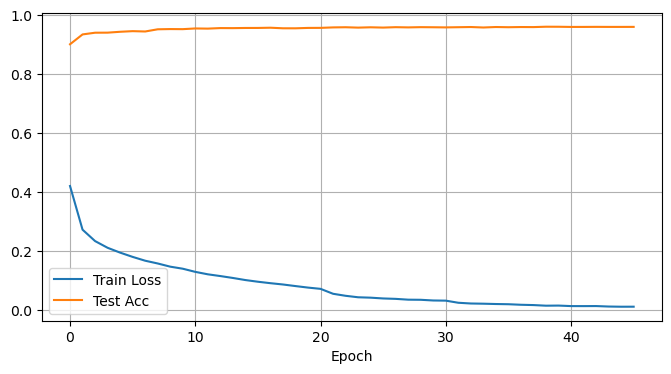

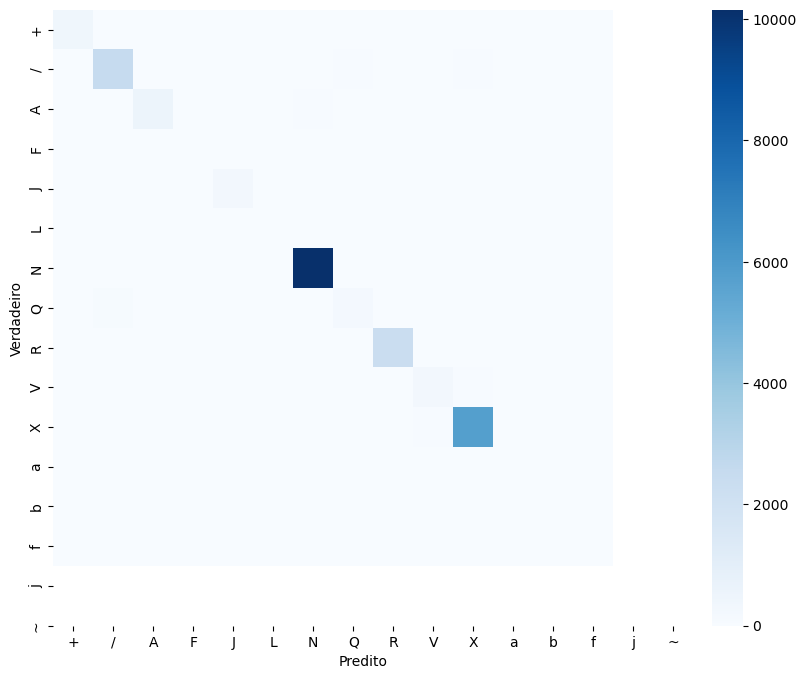

              precision    recall  f1-score   support

           +     0.8940    0.9492    0.9208       453
           /     0.9500    0.9440    0.9470      2716
           A     0.9014    0.8425    0.8710       673
           F     0.3125    0.2000    0.2439        25
           J     0.8725    0.8603    0.8664       358
           L     0.0000    0.0000    0.0000         1
           N     0.9892    0.9939    0.9916     10216
           Q     0.7363    0.5697    0.6424       402
           R     0.9813    0.9933    0.9873      2378
           V     0.6804    0.7805    0.7271       401
           X     0.9631    0.9732    0.9681      5925
           a     0.6667    0.1212    0.2051        33
           b     0.0000    0.0000    0.0000         0
           f     0.0000    0.0000    0.0000         4
           j     0.0000    0.0000    0.0000         0
           ~     0.5833    0.2593    0.3590        54

    accuracy                         0.9610     23639
   macro avg     0.5957   

In [1]:
import os
import numpy as np
import wfdb
from scipy.signal import butter, sosfiltfilt, iirnotch, filtfilt, find_peaks, resample

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# === 0) RANDOM SEED & DEVICE ===
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = DEVICE.type == 'cuda'

# === 1) GENERAL PARAMETERS ===
DATA_DIR    = r'C:\Users\Stella\Desktop\TCC\db'
FS          = 977
WINDOW_MS   = 300
WINDOW_SIZE = int(FS * WINDOW_MS / 1000)

BATCH_SIZE  = 128
LR          = 1e-3
EPOCHS      = 50

# === 2) LOAD RECORDS & MAP SYMBOLS ===
with open(os.path.join(DATA_DIR, 'RECORDS')) as f:
    records = [r.strip() for r in f if r.strip()]

symbol_set = set()
for rec in records:
    ann = wfdb.rdann(os.path.join(DATA_DIR, rec), 'atr')
    symbol_set.update(ann.symbol)
SYMBOL_LIST = sorted(symbol_set)
SYM2IDX     = {s: i for i, s in enumerate(SYMBOL_LIST)}
N_CLASSES   = len(SYMBOL_LIST)
print(f"→ {len(records)} registros, {N_CLASSES} classes: {SYMBOL_LIST}")

# === 3) BEAT EXTRACTION FUNCTION ===
def extract_beats(rec_name):
    rec = wfdb.rdrecord(os.path.join(DATA_DIR, rec_name))
    ann = wfdb.rdann(os.path.join(DATA_DIR, rec_name), 'atr')
    sig = rec.p_signal[:, 0]
    half = WINDOW_SIZE // 2
    Xb, yb = [], []
    for samp, sym in zip(ann.sample, ann.symbol):
        st, ed = samp - half, samp + half
        if st < 0 or ed > len(sig):
            continue
        beat = sig[st:ed]
        if beat.shape[0] != WINDOW_SIZE:
            beat = resample(beat, WINDOW_SIZE)
        Xb.append(beat)
        yb.append(SYM2IDX[sym])
    return np.array(Xb, dtype=np.float32), np.array(yb, dtype=np.int64)

# === 4) BUILD DATASET ===
X_list, y_list = [], []
for rec in records:
    xb, yb = extract_beats(rec)
    X_list.append(xb)
    y_list.append(yb)
X = np.vstack(X_list)
y = np.hstack(y_list)
print(f"→ Extraídos {X.shape[0]} batimentos x {X.shape[1]} amostras")

# === 5) NORMALIZE & SPLIT 80/20 ===
X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
X = X[:, None, :]

rng = np.random.RandomState(SEED)
idx = rng.permutation(len(X))
split = int(0.8 * len(X))
train_idx, test_idx = idx[:split], idx[split:]
X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# === 6) DATALOADERS ===
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(
    ECGDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4 if DEVICE.type=='cuda' else 0, pin_memory=DEVICE.type=='cuda'
)
test_loader = DataLoader(
    ECGDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4 if DEVICE.type=='cuda' else 0, pin_memory=DEVICE.type=='cuda'
)

# === 7) MODEL DEFINITION ===
class ECGNet_v2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 3, padding=1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(128, 256, 3, padding=1), nn.BatchNorm1d(256), nn.ReLU(), nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((WINDOW_SIZE // 16) * 256, 128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
    def forward(self, x): return self.net(x)

model = ECGNet_v2(N_CLASSES).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
scaler = GradScaler(enabled=USE_AMP)

# === 8) TRAIN LOOP WITH EARLY STOPPING ===
best_acc, patience = 0.0, 0
train_losses, test_accs = [], []
for ep in range(1, EPOCHS + 1):
    model.train(); running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        # autocast requires explicit device_type
        with autocast(device_type=DEVICE.type, enabled=USE_AMP):
            preds = model(xb)
            loss = criterion(preds, yb)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()
        running_loss += loss.item() * xb.size(0)
    tr_loss = running_loss / len(train_loader.dataset); train_losses.append(tr_loss)

    model.eval(); correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            correct += (model(xb).argmax(1) == yb).sum().item()
    acc = correct / len(test_loader.dataset); test_accs.append(acc); scheduler.step(acc)

    print(f"Epoch {ep}/{EPOCHS} — loss={tr_loss:.4f} — acc={acc:.4f} — lr={optimizer.param_groups[0]['lr']:.2e}")
    if acc > best_acc + 1e-4:
        best_acc = acc; torch.save(model.state_dict(), 'best_ecg_v2.pth'); patience = 0
    else:
        patience += 1
        if patience >= 7:
            print(f"→ EarlyStopping @ epoch {ep}"); break

# === 9) SAVE & FINAL EVALUATION ===
state = torch.load('best_ecg_v2.pth', map_location=DEVICE, weights_only=True)
model.load_state_dict(state); model.cpu()
torch.jit.script(model).save('ecg_v2_ts.pt')
print("Modelos salvos: best_ecg_v2.pth, ecg_v2_ts.pt")

# === 10) PLOTS ===
plt.figure(figsize=(8,4)); plt.plot(train_losses,label='Train Loss'); plt.plot(test_accs,label='Test Acc'); plt.xlabel('Epoch'); plt.legend(); plt.grid(); plt.show()

# === 11) CONFUSION MATRIX & REPORT ===
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        preds = model(xb).argmax(1).cpu().numpy()
        y_pred.extend(preds); y_true.extend(yb.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8)); sns.heatmap(cm, xticklabels=SYMBOL_LIST, yticklabels=SYMBOL_LIST, cmap='Blues', fmt='d')
plt.xlabel('Predito'); plt.ylabel('Verdadeiro'); plt.show()
print(classification_report(y_true, y_pred, labels=list(range(N_CLASSES)), target_names=SYMBOL_LIST, digits=4, zero_division=0))


In [2]:
import wfdb
from collections import Counter

symbols = Counter()
for rec in [f'x00{i+1}' for i in range(10)]:
    ann = wfdb.rdann(f'C:\\Users\\Stella\\Desktop\\TCC\\db\\{rec}', 'atr')
    symbols.update(ann.symbol)

print(symbols['N'])

46057


In [6]:
import os
import wfdb
import numpy as np
import torch
from scipy.signal import resample

# === 1) CONFIGURAÇÕES ===
base_dir     = r'C:\Users\Stella\Desktop\TCC'
record_name  = 'meu_ecg_filtrado'             # sem extensão
record_path  = os.path.join(base_dir, record_name)
MODEL_PATH   = os.path.join(base_dir, 'ecg_v2_ts.pt')
fs           = 977                           # Hz
WINDOW_MS    = 300
WINDOW_SIZE  = int(fs * WINDOW_MS / 1000)    # 293 amostras
half_win     = WINDOW_SIZE // 2

# A mesma lista de símbolos usada no treino
SYMBOL_LIST = ['+', '/', 'A', 'F', 'J', 'L', 'N',
               'Q', 'R', 'V', 'X', 'a', 'b', 'f', 'j', '~']

# === 2) Lê o registro WFDB e anotações (.dat/.hea + .atr) ===
rec = wfdb.rdrecord(record_path)
ann = wfdb.rdann(record_path, 'atr')
sig = rec.p_signal[:, 0]  # canal único de ECG

# === 3) Extrai segmentos de batimentos centrados nos picos anotados ===
beats = []
for samp in ann.sample:
    st, ed = samp - half_win, samp + half_win
    if st < 0 or ed > len(sig):
        continue
    beat = sig[st:ed]
    if beat.shape[0] != WINDOW_SIZE:
        beat = resample(beat, WINDOW_SIZE)
    beats.append(beat)
beats = np.stack(beats, axis=0).astype(np.float32)  # (n_beats, WINDOW_SIZE)

if beats.size == 0:
    raise RuntimeError("Nenhum batimento extraído — verifique seus picos em .atr")

# === 4) Função de classificação reutilizando o modelo scripted ===
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = torch.jit.load(MODEL_PATH, map_location=DEVICE)
model.eval()

def classify_beats(beats_np: np.ndarray):
    # normaliza cada batimento
    m = beats_np.mean(axis=1, keepdims=True)
    s = beats_np.std(axis=1, keepdims=True) + 1e-8
    norm = (beats_np - m) / s

    X = torch.from_numpy(norm).unsqueeze(1).to(DEVICE)  # (n,1,WINDOW_SIZE)
    with torch.no_grad():
        logits = model(X)                            # (n, n_classes)
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        preds  = np.argmax(probs, axis=1)
    return preds, probs

# === 5) Classifica os batimentos extraídos ===
preds, probs = classify_beats(beats)

# === 6) Imprime resultados ===
for i, p in enumerate(preds):
    print(f"Beat {i:>3d}: classe = '{SYMBOL_LIST[p]}', prob = {probs[i,p]:.3f}")

# (Opcional) Resumo de distribuição de classes
unique, counts = np.unique(preds, return_counts=True)
print("\nDistribuição de predições:")
for cls, cnt in zip(unique, counts):
    print(f"  {SYMBOL_LIST[cls]:>2s} : {cnt}")


Beat   0: classe = '/', prob = 1.000
Beat   1: classe = 'X', prob = 0.980
Beat   2: classe = 'X', prob = 0.990
Beat   3: classe = 'X', prob = 0.980
Beat   4: classe = 'X', prob = 0.953
Beat   5: classe = 'X', prob = 0.921
Beat   6: classe = 'X', prob = 0.815
Beat   7: classe = 'X', prob = 0.850
Beat   8: classe = 'X', prob = 0.806
Beat   9: classe = 'X', prob = 0.678
Beat  10: classe = 'X', prob = 0.672
Beat  11: classe = 'X', prob = 0.928
Beat  12: classe = 'X', prob = 0.520
Beat  13: classe = '/', prob = 0.997
Beat  14: classe = 'X', prob = 0.994
Beat  15: classe = 'X', prob = 0.986
Beat  16: classe = 'X', prob = 0.997
Beat  17: classe = 'X', prob = 0.929
Beat  18: classe = 'X', prob = 0.998
Beat  19: classe = 'X', prob = 0.992

Distribuição de predições:
   / : 2
   X : 18


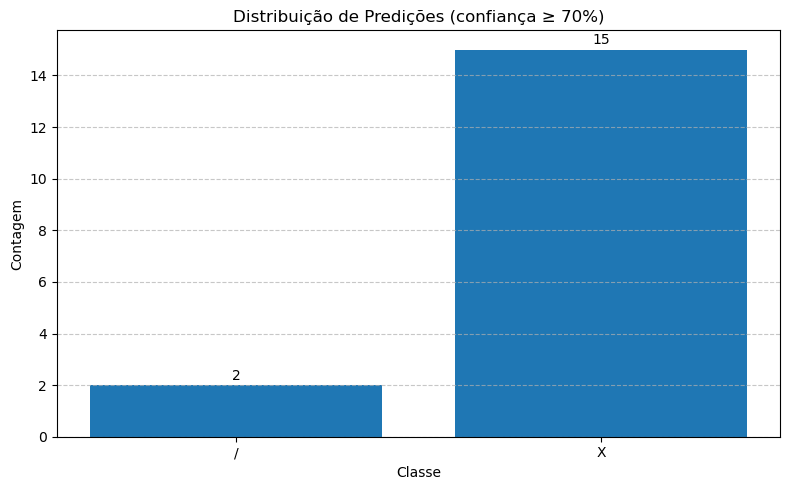

In [7]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_distribution_with_confidence(preds, probs, class_names=None,
                                      threshold=0.7,
                                      title="Distribuição de Predições (confiança ≥ {:.0%})",
                                      xlabel="Classe", ylabel="Contagem",
                                      figsize=(8, 5)):
    """
    Plota um gráfico de barras com a contagem de cada classe em `preds`,
    incluindo apenas batimentos cuja probabilidade máxima em `probs` seja ≥ threshold.
    
    Args:
      preds (array-like, shape [n_beats,]): índices de classe previstos.
      probs (array-like, shape [n_beats, n_classes]): probabilidades por batimento.
      class_names (list of str, opcional): nomes de cada índice de classe.
      threshold (float): probabilidade mínima para incluir um batimento.
      title, xlabel, ylabel (str): rótulos do gráfico.
      figsize (tuple): tamanho da figura.
    """
    preds = np.asarray(preds)
    probs = np.asarray(probs)
    
    # máscara de confiança
    confidences = probs.max(axis=1)
    mask = confidences >= threshold
    
    # filtra apenas os preds confiáveis
    filtered = preds[mask]
    if filtered.size == 0:
        print(f"Nenhum batimento com confiança ≥ {threshold:.2f}.")
        return
    
    # conta frequências
    counts = Counter(filtered)
    labels = sorted(counts.keys())
    values = [counts[k] for k in labels]
    
    # converte para nomes, se fornecido
    if class_names is not None:
        labels = [class_names[k] for k in labels]
    else:
        labels = [str(k) for k in labels]
    
    # cria plot
    plt.figure(figsize=figsize)
    bars = plt.bar(labels, values)
    plt.title(title.format(threshold))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # anota valores
    for bar, v in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, v + 0.1, str(v),
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# ========================
# Exemplo de uso:
# ========================
# preds = np.array([ ... ])           # shape (n_beats,)
# probs = np.array([...])             # shape (n_beats, n_classes)
# SYMBOL_LIST = ['+', '/', 'A', ..., '~']
plot_distribution_with_confidence(preds, probs, class_names=SYMBOL_LIST, threshold=0.7)


In [11]:
import pandas as pd

# Definição da tabela de símbolos e descrições MIT-BIH
symbols = ['+', '/', 'A', 'a', 'J', 'j', 'N', 'L', 'R', 'V', 'F', 'f', 'Q', 'X', 'b', '~']
descriptions = [
    "Onda P detectada",
    "Batimento estimulado por marcapasso",
    "Batimento atrial prematuro",
    "Batimento atrial prematuro aberrante",
    "Batimento nodal prematuro",
    "Batimento nodal de escape",
    "Batimento normal",
    "Batimento com bloqueio de ramo esquerdo",
    "Batimento com bloqueio de ramo direito",
    "Contração ventricular prematura",
    "Fusão de batimento ventricular e normal",
    "Fusão de batimento estimulado e normal",
    "Batimento não classificável",
    "P-wave não conduzida (bloqueio AP)",
    "Símbolo sem definição oficial MIT-BIH",
    "Mudança na qualidade do sinal"
]

# Cria DataFrame
df = pd.DataFrame({
    "Símbolo": symbols,
    "Descrição": descriptions
})

# Exibe tabela
print(df)


   Símbolo                                Descrição
0        +                         Onda P detectada
1        /      Batimento estimulado por marcapasso
2        A               Batimento atrial prematuro
3        a     Batimento atrial prematuro aberrante
4        J                Batimento nodal prematuro
5        j                Batimento nodal de escape
6        N                         Batimento normal
7        L  Batimento com bloqueio de ramo esquerdo
8        R   Batimento com bloqueio de ramo direito
9        V          Contração ventricular prematura
10       F  Fusão de batimento ventricular e normal
11       f   Fusão de batimento estimulado e normal
12       Q              Batimento não classificável
13       X       P-wave não conduzida (bloqueio AP)
14       b    Símbolo sem definição oficial MIT-BIH
15       ~            Mudança na qualidade do sinal


In [12]:
preds, probs = classify_beats(beats)

In [13]:
SYMBOL_LIST[p]

'X'

In [ ]:
# 1) Pegue as probabilidades de um batch qualquer (aqui, só o primeiro beat)
_, sample_probs = classify_beats(beats[:1])

# 2) Verifique se o número de classes do modelo bate com o tamanho da lista
n_classes_model = sample_probs.shape[1]
assert n_classes_model == len(SYMBOL_LIST), (
    f"Modelo retorna {n_classes_model} classes, "
    f"mas SYMBOL_LIST tem {len(SYMBOL_LIST)} símbolos."
)

print("✅ Mapeamento está coerente: cada índice de predição corresponde ao símbolo correto.")

In [ ]:
top2 = np.argsort(probs[i])[-2:]    # índices das duas maiores classes
print(probs[i, top2])               # exibe confidências para essas 2


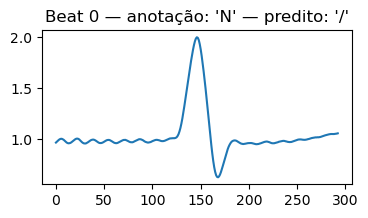

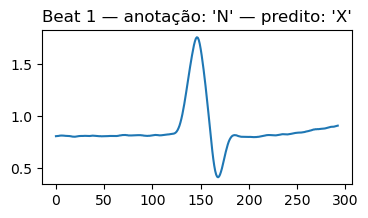

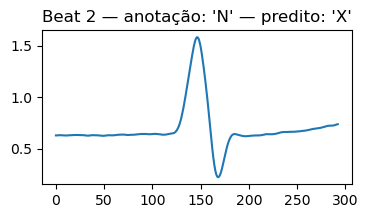

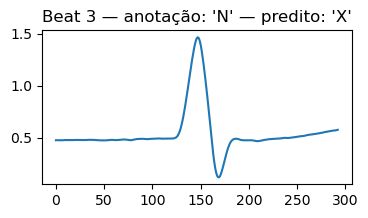

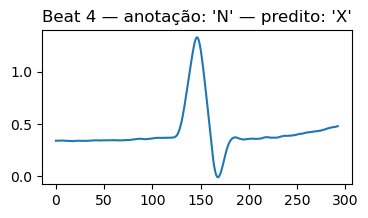

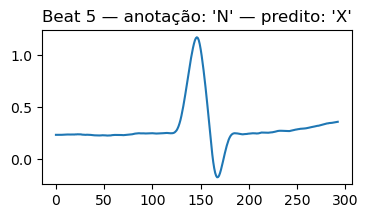

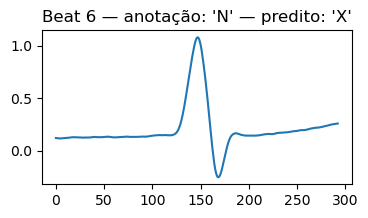

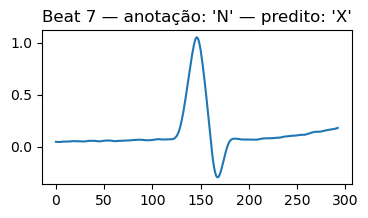

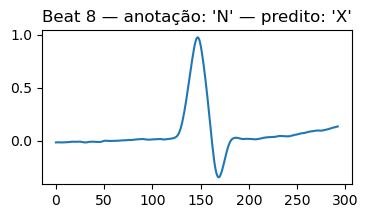

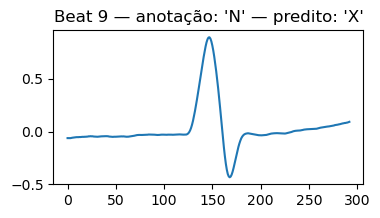

In [14]:
import matplotlib.pyplot as plt

# exibe os primeiros 5 beats do seu sinal
for idx in range(10):
    plt.figure(figsize=(4,2))
    plt.plot(beats[idx])
    plt.title(f"Beat {idx} — anotação: 'N' — predito: '{SYMBOL_LIST[preds[idx]]}'")
    plt.show()
